# Libraries

In [ ]:
%pylab inline
import Tools.ext as Te
import Tools.display as Td
import Tools.matrices as Tm
import Tools.functions as Tf
import pandas as pd
from IPython.display import HTML

# Loading

In [2]:
dir_86 = '../../../TimeCourses/Jonathan/86/'
dir_512 = '../../../TimeCourses/Jonathan/512/'
dir_nEEG = '../../../TimeCourses/Jonathan/86_noEEG/'
Reg0 = 'grey_matter_sansSB_sansLCR/'
Reg1 = 'grey_matter_sansSB_sansLCR_sansGlobMean/'

In [3]:
cen86 = Te.data2array('../../../Connectomes/Jonathan/86/centres/t10.txt')
cen512 = Te.data2array('../../../Connectomes/Jonathan/512/centres/p06.npy')[:,1:]
or86 = Te.data2array('../../../Connectomes/Jonathan/ReorderByHemi86.txt').astype(int)[0]
dow = Te.data2array('../../../Connectomes/Jonathan/AAL512_to_AAL86.txt')[0].astype(int)
lbl = Te.data2array('../../../Connectomes/Jonathan/AAL.npy', dic=1)
MHub = Te.data2array('./MDFC/clus_indices.npy', dic=1)

In [4]:
KS1 = sorted([k.rstrip('.txt') for k in Te.os.listdir(dir_86 + Reg0)])
KS2 = sorted([k.rstrip('.txt') for k in Te.os.listdir(dir_nEEG + Reg0)])

In [5]:
TC = {'86u':{},'86r':{},'512u':{},'512r':{}}
for typ, di, sub in [['86u',  dir_86,   Reg0], ['86r',  dir_86,   Reg1],
                     ['512u', dir_512,  Reg0], ['512r', dir_512,  Reg1]]:
    for k in KS1:
        TC[typ][k] = Te.data2array(di + sub + k + '.txt', finite=True).T

# Dynamical Functional Connectivity

In [ ]:
# 7h
Td.tic()
for w in range(4,31):
    for typ in TC.keys():
        try:    
            to_save = Te.data2array('./MDFC/win_%i_typ_%s.npy'%(w,typ), dic=1)
        except: 
            to_save = {}
            N = int(typ[:-1])

            if N == 512:
                for k in KS1:
                    try:    to_save[k]
                    except: to_save[k] = {}

                    FCs = Tf.windowedFCs(TC[typ][k].T, window=w)

                    for H in MHub.keys():
                        try:
                            to_save[k][H]

                        except:
                            iNs = array(MHub[H]['ind'])
                            to_save[k][H] = Tf.fPearsonCorrelation(FCs.reshape((len(FCs), N*N)).T[iNs])

                    del FCs

                Te.array2data(to_save, './MDFC/win_%i_typ_%s.npy'%(w,typ))
                del to_save

In [7]:
# 6 minutes
# S[dim] = [regression] x [patients/controls + p_val] x [Hub] x [w] x [tau] x [metric]
try:
    S = Te.data2array('MDFC/S6D.npy')
except:
    S = zeros((2, 21+1, 11, 27, 57, 3))

    Td.tic()
    for ir, r in zip([0,1], ['u','r']):
        typ = '512'+r

        for iw, w in zip(range(27), range(4,31)):
            MDFC = Te.data2array('./MDFC/win_%i_typ_%s.npy'%(w,typ), dic=1)

            for iH, H in zip(range(11), MHub.keys()):
                for ik, k in zip(range(21), KS1):
                    DDD = MDFC[k][H]

                    for itau, tau in zip(range(57), range(4,61)):
                        try:
                            dists = 1.- diag(DDD, k=tau)
                        except:
                            dists = []

                        if len(dists) > 3:
                            h1, b1 = histogram(dists, bins=2*Td.nbChiHist(dists))
                            h2, b2 = histogram(dists, bins=sqrt(len(dists)))
                            h3, b3 = histogram(dists, bins=ceil(log2(len(dists))+1))
                            h, b = [[h1,b1], [h2,b2], [h3,b3]][argmax([h1.max(), h2.max(), h3.max()])]

                            S[ir, ik, iH, iw, itau, 0] = b[h.argmax()]
                            S[ir, ik, iH, iw, itau, 1] = std(dists)
                            S[ir, ik, iH, iw, itau, 2] = median(dists)

                        else:
                            pass #print 'len(dists) <= 3', w, typ, k, tau

                for itau, tau in zip(range(57), range(4,61)):
                    for i in range(3):
                        pat = S[ir, 0:7,  iH, iw, itau, i]
                        con = S[ir, 7:21, iH, iw, itau, i]
                        S[ir, -1, iH, iw, itau, i] = ranksums(pat, con)[1] * (-1) ** (mean(pat) > mean(con))

    Te.array2data(S, 'MDFC/S6D.npy')
    Td.tac()

In [8]:
def maps(S, fmt='%.2f', nl=2, nc=6, ek=0.05, fs=(15,4)):
    fig = figure(figsize=fs)
    
    for i in range(11):
        ax = fig.add_subplot(nl,nc,i+1)
        m, M = S[i].min(), S[i].max()
            
        if i%nc == 0:
            ax.set_ylabel(r'$w$', fontsize=18)
            ax.set_yticks([0,26])
            ax.set_yticklabels([30,4])
        else:
            ax.set_yticklabels([])
        ax.set_xticklabels([])
        if i >= nc * (nl-1):
            ax.set_xlabel(r'$\tau$', fontsize=18)
            ax.set_xticks([0,56])
            ax.set_xticklabels([4,60])
        ax.set_title(i)
            
        im = ax.imshow(S[i,::-1], aspect='auto', vmax=M, vmin=m)
        if i == 10:
            cb = fig.colorbar(im, ax=ax, format=fmt)
            cb.set_ticks([m, 0, M])
        
        
    fig = figure(figsize=fs)
    dS = abs(S)
    for i in range(11):
        ax = fig.add_subplot(nl,nc,i+1)
            
        if i%nc == 0:
            ax.set_ylabel(r'$w$', fontsize=18)
            ax.set_yticks([0,26])
            ax.set_yticklabels([30,4])
        else:
            ax.set_yticklabels([])
        ax.set_xticklabels([])
        if i >= nc * (nl-1):
            ax.set_xlabel(r'$\tau$', fontsize=18)
            ax.set_xticks([0,56])
            ax.set_xticklabels([4,60])
        ax.set_title(i)
            
        im = ax.imshow(dS[i,::-1], aspect='auto', vmax=ek, vmin=0, cmap='RdYlGn_r')
        if i == 10:
            cb = fig.colorbar(im, ax=ax, format=fmt)

# UNREGRESSED

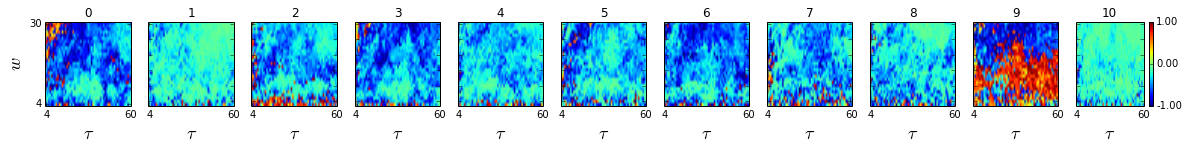

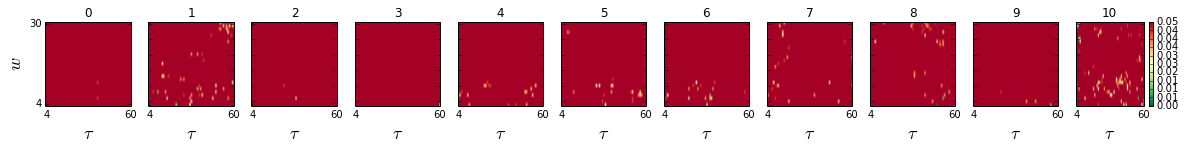

In [26]:
# MAXS
maps(S[0,-1,:,:,:,0], nl=1, nc=11, fs=(20,1.5))

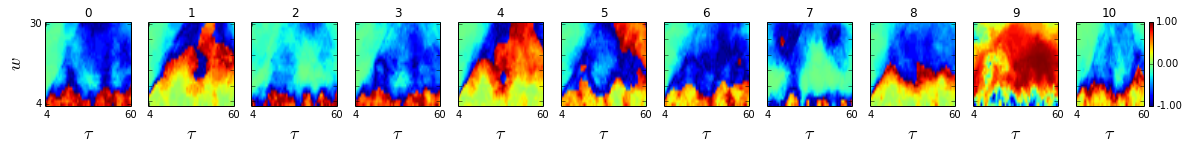

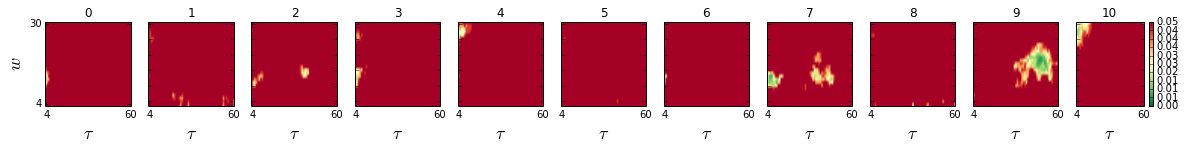

In [27]:
# DEVIATIONS
maps(S[0,-1,:,:,:,1], nl=1, nc=11, fs=(20,1.5))

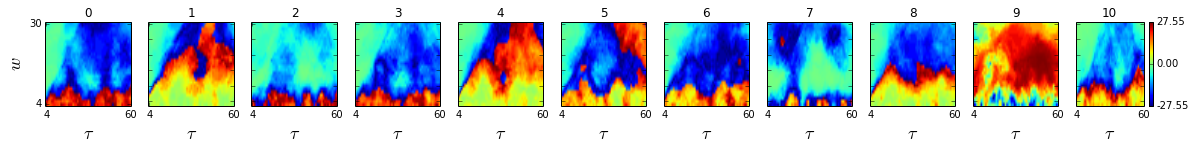

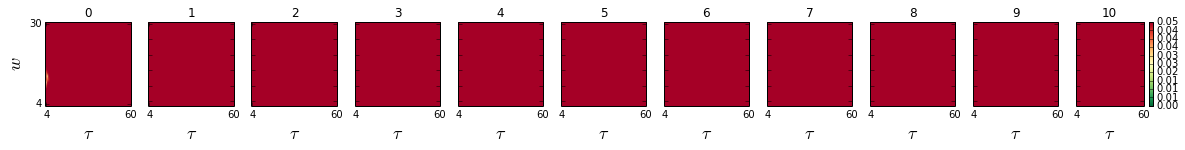

In [12]:
# DEVIATIONS
maps(S[0,-1,:,:,:,1] * 130816 / array([102208,10929,19564,36272,11135,4372,19420,3413,6666,951,4748])[:,newaxis,newaxis],
     nl=1, nc=11, fs=(20,1.5), ek=0.05)

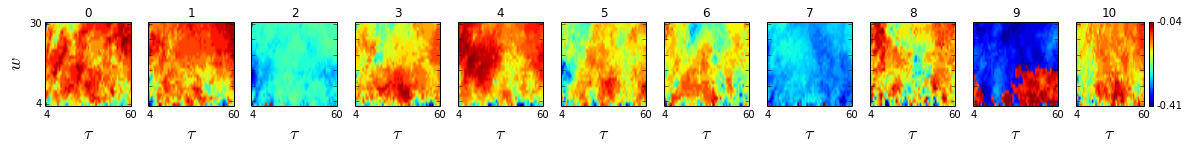

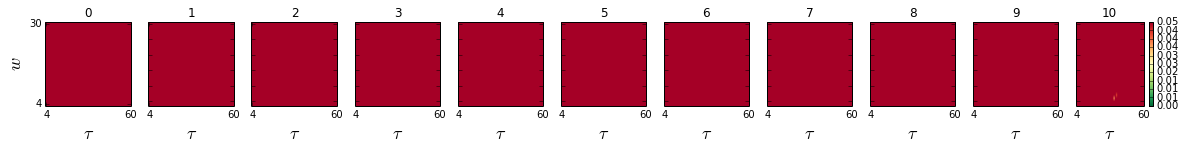

In [28]:
# MEDIANS
maps(S[0,-1,:,:,:,2], nl=1, nc=11, fs=(20,1.5))

# REGRESSED

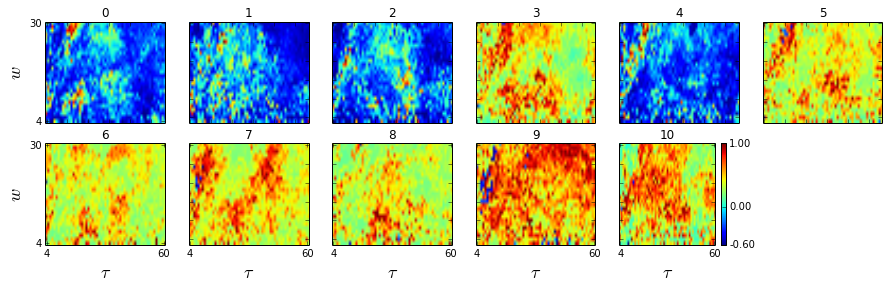

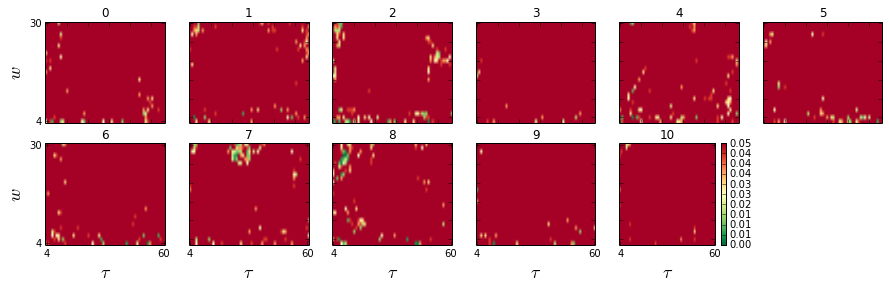

In [16]:
# MAXS
maps(S[1,-1,:,:,:,0])

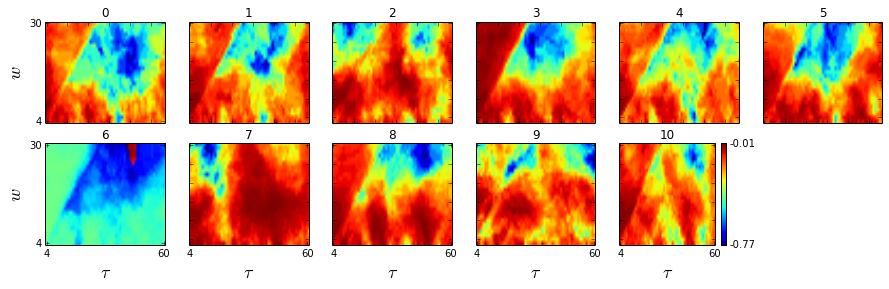

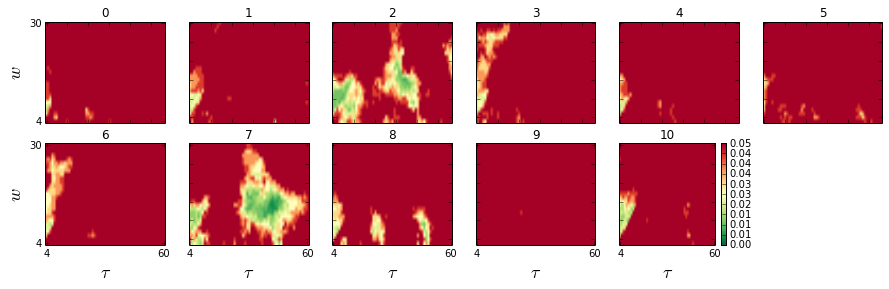

In [17]:
# DEVIATIONS
maps(S[1,-1,:,:,:,1])

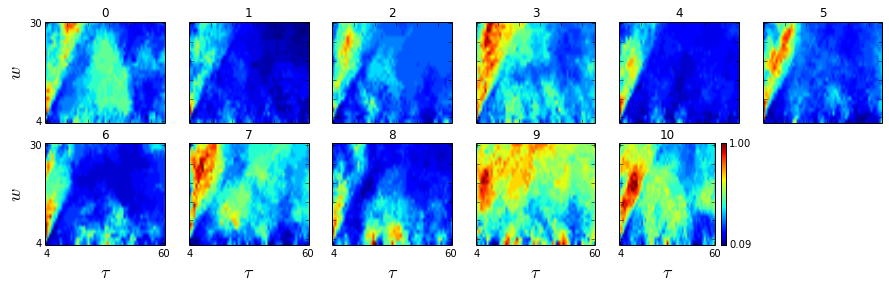

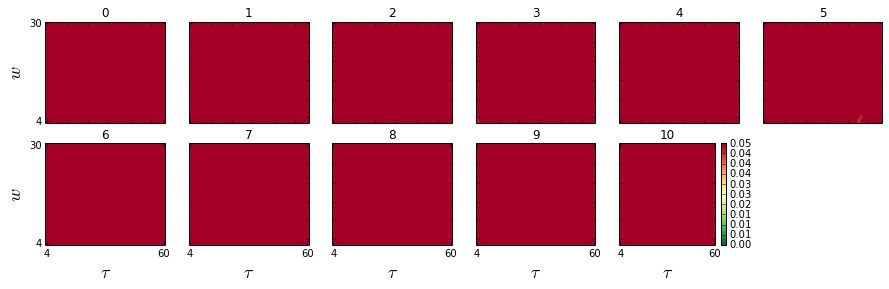

In [18]:
# MEDIANS
maps(S[1,-1,:,:,:,2])